# STAYSL Walk-through NIF
This example walks through the 
Passive 18x snout on TANDM 90-348 NIF Foil Activation Experiment performed by
Energetic Neutron Platform Working Group and NIF Radiochemistry Group

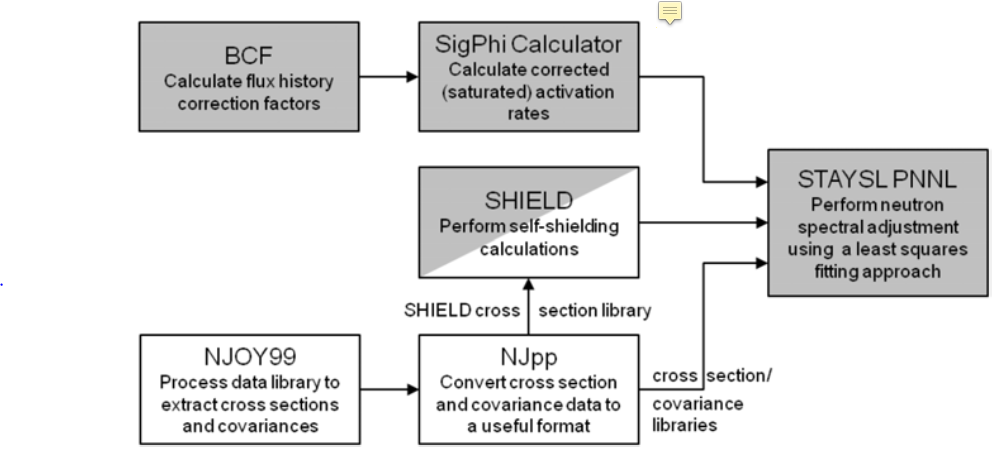
- This is from EPJWeb of Conferences 106, 07001 (2016) Least-Squares Neutron Spectral Adjustment with STAYSL PNNL L.R. Greenwooda and C.D. Johnson

# BCF - Beam Correction Factor
BCF corrects for irradiation history. The calculations performed correct for production and decay during the irradiation. At constant power or flux, this is a simple process 

$A_{0}=A_{\infty}*(1-exp(-\lambda*t))$

BCF normalizes the irradiation history to the time-weighted average reactor power or beam current. A correction factor is produced based on the irradiation hisotry for each isotope of interest. 

For the NIF, this module is not needed, BCF is not needef for a short irradiation time

## SHIELD
The SHIELD code calculates energy-dependent neutron self-shielding cross section correction factors that are used, prior to neutron spectral adjustment, to shield the neutron activation cross sections used by the STAYSL PNNL code. 

SHIELD was performed on ["shldinputNIF.dat"](https://github.com/nickquartemont/NENG612/tree/master/NIF_Unfold/Unfold/SHIELD/shldinputNIF.dat). 

After a painstaking process of trial and error. It was determined that my executable of the SHIELD.exe can only be ran if: 
- Run command prompt as an administrator
- Use runExample batch file with filename replaced with desired input

I am unsure of why it requires this, I am guessing it is a permissions issue that I cannot work out. 

SHIELD is only necessary/valid on non-threshold reactions (n,gamma). SHIELD is dependent on the thickness of the material, so it must be re-ran if different foils/wires are used. 

An output file is created in the same directory shldinput.out

All foils are 1 mm (39.3701 mils) except for the Au foils, which are 0.1 mm

The output is renamed sshldlib.dat


## SigPhi Calculator

The [SigPhi Calculator](https://github.com/nickquartemont/NENG612/tree/master/NIF_Unfold/Unfold/SIGPHI/SigPhi_Calculator_NIF.xlsm) was filled in with data from the [foil and activity information] (https://github.com/nickquartemont/NENG612/tree/master/NIF_Unfold/ActivationData.xlsx)


The purpose of the SigPhi Calculator software is to calculate corrected saturated neutron activation rates from measured activities. These reaction rates, the so-called sig-phi values, represent the product of the spectral-averaged neutron activation cross section and the total neutron flux

The NIF is a very prompt output (~200 ps). There will be some downscatter which may slow a portion down. However, for the purposes of the irradiation, the irradiation time is taken as 1 second, and the reaction rates are taken as per second. This will not impact the results because the half-lives of the measured products are orders of magnitude different from this result. 

The export to excel did not work. Instead, the input was built-up using the calculated gamma shielding and At/At-s from the foil and activity information sheet

I couldn't get the SigPhi Calculator to work for me. I redownloaded everything and it gives me: 
￿￿￿￿￿￿￿￿￿￿ when I try to export to a STAYSL script. After this is completed. I plan on sending in the bugs to PNNL

The sig-phi is calculated by dividing the number of nuclei created at t0 by the total number of atoms present in the foil. This is the relative production. 

The self-shielding factor for gammas is divided by this to correct for gamma self-shielding


# STAYSL

The STAYSL input deck was made with the SIG_PHI calculator and foil/activation data. 

The default values (From examples distributed with STAYSL) for Gaussian formalism were used. 

An iterative solution was performed on the input data and sets the uncertainty below 13 MeV to 100%. This was chosen because the model did not predict the down-scattering well. The baseline guess spectrum was initially developed using an Appelbe source split with a 14.03 MeV neutron peak at 10.75 keV temperature (See foil/activation Excel doc). 

After the initial results from the Appelbe source, it was clear that there was a large downscattering term. 

An estimation of the foil (13-14 MeV and 14-15 MeV) flux was done in the activation spreadsheet. The (n,2n) reactions were almost exactly what the guess predicted; however, the (n,g) and (n,n') reactions were underpredicting by over an order of magnitude. 

The guess spectrum was changed to a previous NIF shot. 

In [14]:
import sys
import os
sys.path.insert(0,os.path.abspath('C:/Users/nickq/Documents/AFIT_Masters/PyScripts/src'))
import pandas as pd
from DataAnalysis.DataManipulation import bin_integration, bin_differentiation
from DataAnalysis.Histograms import Histogram
import matplotlib
from Unfolding.STAYSL import IterativeSTAYSL

%matplotlib inline
import scipy.stats as stats
#http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-25-chi.html

STAYSL is ran by executing the executable from the command line. The first iteration of STAYSL is performed manually. The output from that is placed into folder Iteration1. 

# Pinhole Results

In [18]:


path = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/stayslin.out'
df = pd.read_table(path, engine='python', sep='\s+', skiprows=101, skipfooter=649, header=None,
                   names=['lowE', 'adjFlux', 'unadjFlux', 'fluxRatio', 'adjStd', 
                          'unadjStd', 'uncertRatio', 'integralFlux', 'intFluxUncert'])

df.apply(pd.to_numeric)

df['adjFlux'] = bin_integration(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low')
df['adjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low', True)
df['unadjFlux'] = bin_integration(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low')
df['unadjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low', True)

df['adjLethargyStd'] = df['adjStd'] * df['adjLethargy'] / 100
df['unadjLethargyStd'] = df['unadjStd'] * df['adjLethargy'] / 100
df['adjStd'] = df['adjStd'] * df['adjFlux'] / 100
df['unadjStd'] = df['unadjStd'] * df['unadjFlux'] / 100

#df['adjStd']

Plot first result

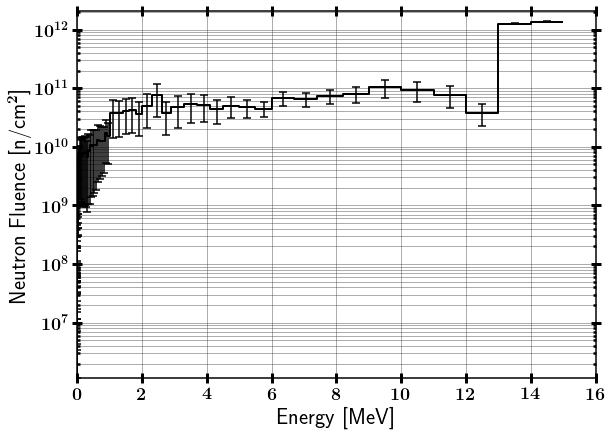

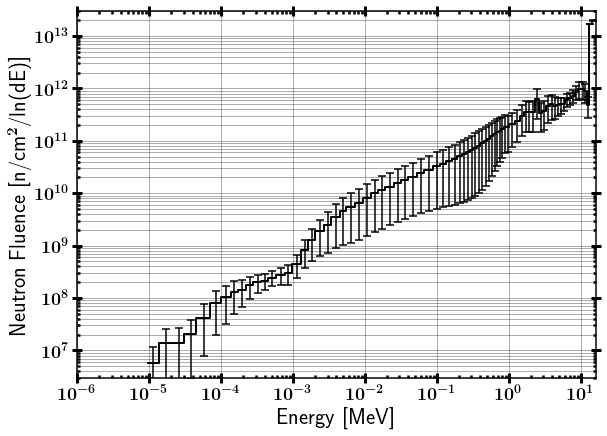

In [19]:


outpath ='C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/'
adjHisto = Histogram()
adjHisto.build_histo(df['lowE'].tolist(), df['adjFlux'].tolist(), uncert=df['adjStd'].tolist(),
                     edgeLoc='low')

adjHisto.plot(xMin=1E-6, logX=False, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',
                  savePath=outpath+'Pin1',includeMarkers=False,
                  legend=False)
adjLethargyHisto = Histogram()
adjLethargyHisto.build_histo(df['lowE'].tolist(), df['adjLethargy'].tolist(), uncert=df['adjLethargyStd'].tolist(),
                     edgeLoc='low')

adjLethargyHisto.plot( xMin=1E-6, logX=True, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$/ln(dE)]',
                  savePath=outpath+'Pin1d_Lethargic',includeMarkers=False,
                  legend=False)

# Pin Iterative Solution:
  - The iterative solution sets the uncertainty below 13 MeV to 100%.
  - It does not update the uncertainty until $\chi^2$ converged.

In [20]:
from Unfolding.STAYSL import IterativeSTAYSL

stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration1/'

# Build Data Structure Lists
iterSoln = []
iterAdjHisto = []
iterRatioHisto = []

iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=False, chiConv=0.1))
print iterSoln[-1]

iterSoln[-1].run()

# Convert to lethargy
iterSoln[-1]._df['adjLethargy'] =  bin_differentiation(iterSoln[-1]._df['lowE'].tolist(),
                                                     iterSoln[-1]._df['adjFlux'].tolist(), 'low', True)

# Add to plot lists
iterAdjHisto.append(Histogram())
iterRatioHisto.append(Histogram())

IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration1/
$\chi^2$ Convergence: 0.1
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: False
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration1/stayslin.out
Chi^2 = 34.06233, Std Norm = 6.20822220527
Chi^2 = 20.66275
Chi^2 = 15.64945
Chi^2 = 13.50027
Chi^2 = 12.03089
Chi^2 = 10.80222
Chi^2 = 9.82855
Chi^2 = 9.00026
Chi^2 = 8.3121
Chi^2 = 7.72605
Chi^2 = 7.2275
Chi^2 = 6.79891
Chi^2 = 6.42842
Chi^2 = 6.10673
Chi^2 = 5.82561
Chi^2 = 5.57934
Chi^2 = 5.36202
Chi^2 = 5.17007
Chi^2 = 4.9996
Chi^2 = 4.84776
Chi^2 = 4.712
Chi^2 = 4.59037
Chi^2 = 4.48087
Chi^2 = 4.38187
Std Norm = 7.43564433926, 7.12396212862
Std Norm = 7.434369557, 7.43564433926


1


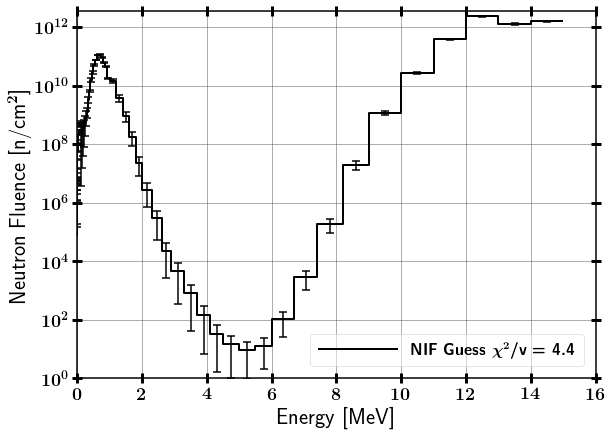

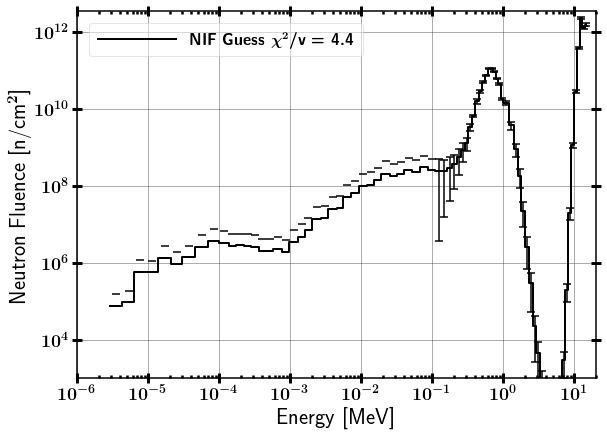

In [55]:
print len(iterAdjHisto)
iter = 0
iterAdjHisto[iter].build_histo(iterSoln[iter]._df['lowE'].tolist(),iterSoln[iter]._df['adjFlux'].tolist(),
                             uncert=(iterSoln[iter]._df['adjStd']*iterSoln[iter]._df['adjFlux']).tolist(),
                             edgeLoc='low', name='\\textbf{NIF Guess $\chi^{2}$/v = 4.4}')

iterAdjHisto[iter].plot(xMin=1E-8, xMax=16, yMin=1, logX=False, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',
                        savePath=outpath+'PIN-Unfold_Itr{:1d}'.format(iter),legendLoc=4)
iterAdjHisto[iter].plot(xMin=1E-6, xMax=20, yMin=1000, logX=True, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',
                        savePath=outpath+'PINlog-Unfold_Itr{:1d}'.format(iter),legendLoc=2)



Find the p value 

In [117]:

crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 4)   # Df = number of variable categories - 1

print("Critical value")
print(crit)

p_value= stats.chi2.sf(4.38*4, 4) 
print("P value")
print(p_value)

Critical value
9.48772903678
P value
2.62785370057e-05


# Pinhole Results
- Starting from Flat Spectrum 

In [28]:
import pandas as pd
from DataAnalysis.DataManipulation import bin_integration, bin_differentiation

path = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_flat/stayslin.out'
df = pd.read_table(path, engine='python', sep='\s+', skiprows=101, skipfooter=649, header=None,
                   names=['lowE', 'adjFlux', 'unadjFlux', 'fluxRatio', 'adjStd', 
                          'unadjStd', 'uncertRatio', 'integralFlux', 'intFluxUncert'])

df.apply(pd.to_numeric)

df['adjFlux'] = bin_integration(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low')
df['adjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low', True)
df['unadjFlux'] = bin_integration(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low')
df['unadjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low', True)

df['adjLethargyStd'] = df['adjStd'] * df['adjLethargy'] / 100
df['unadjLethargyStd'] = df['unadjStd'] * df['adjLethargy'] / 100
df['adjStd'] = df['adjStd'] * df['adjFlux'] / 100
df['unadjStd'] = df['unadjStd'] * df['unadjFlux'] / 100

#df['adjStd']

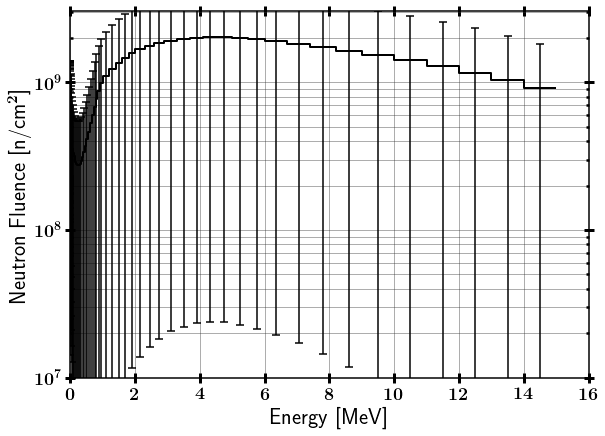

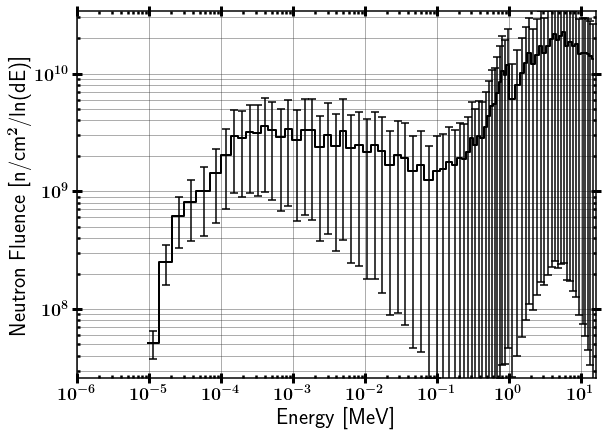

In [29]:
from DataAnalysis.Histograms import Histogram
import matplotlib
%matplotlib inline

outpath ='C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_flat/'
fadjHisto = Histogram()
fadjHisto.build_histo(df['lowE'].tolist(), df['adjFlux'].tolist(), uncert=df['adjStd'].tolist(),
                     edgeLoc='low')

fadjHisto.plot(xMin=1E-6, logX=False, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',
                  savePath=outpath+'Pin1',includeMarkers=False,
                  legend=False)
fadjLethargyHisto = Histogram()
fadjLethargyHisto.build_histo(df['lowE'].tolist(), df['adjLethargy'].tolist(), uncert=df['adjLethargyStd'].tolist(),
                     edgeLoc='low')

fadjLethargyHisto.plot( xMin=1E-6, logX=True, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$/ln(dE)]',
                  savePath=outpath+'Pin1d_Lethargic',includeMarkers=False,
                  legend=False)

# Flat Spectrum Pin Iterative Solution:
  - Start from Flat spectrum
  - The iterative solution sets all uncertainties to 100%.
  - It does not update the uncertainty until $\chi^2$ converged.

In [30]:
from Unfolding.STAYSL import IterativeSTAYSL

stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/PIN_N120405_flat/Iteration1/'

# Build Data Structure Lists
fiterSoln = []
fiterAdjHisto = []
fiterRatioHisto = []

fiterSoln.append(IterativeSTAYSL(stayslPath, updateStd=False, chiConv=0.1))
print iterSoln[-1]

fiterSoln[-1].run()

# Convert to lethargy
fiterSoln[-1]._df['adjLethargy'] =  bin_differentiation(fiterSoln[-1]._df['lowE'].tolist(),
                                                     fiterSoln[-1]._df['adjFlux'].tolist(), 'low', True)

# Add to plot lists
fiterAdjHisto.append(Histogram())
fiterRatioHisto.append(Histogram())

IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration1/
$\chi^2$ Convergence: 0.1
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: True
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/PIN_N120405_flat/Iteration1/stayslin.out
Chi^2 = 5727.00122, Std Norm = 8.07825657986
Chi^2 = 3162.6634
Chi^2 = 982.24481
Chi^2 = 17.43754
Chi^2 = 8.98512
Chi^2 = 8.50568
Chi^2 = 8.16159
Chi^2 = 7.86907
Chi^2 = 7.62109
Chi^2 = 7.41214
Chi^2 = 7.2348
Chi^2 = 7.08236
Chi^2 = 6.94928
Chi^2 = 6.83089
Chi^2 = 6.72391
Chi^2 = 6.62567
Std Norm = 5.47958014906, 6.81473082447
Std Norm = 5.47769612794, 5.47958014906


1


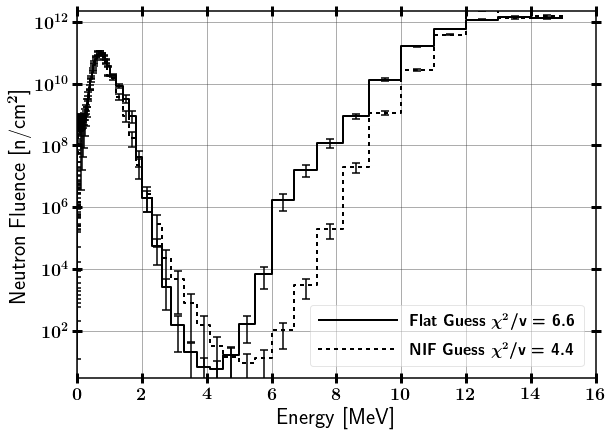

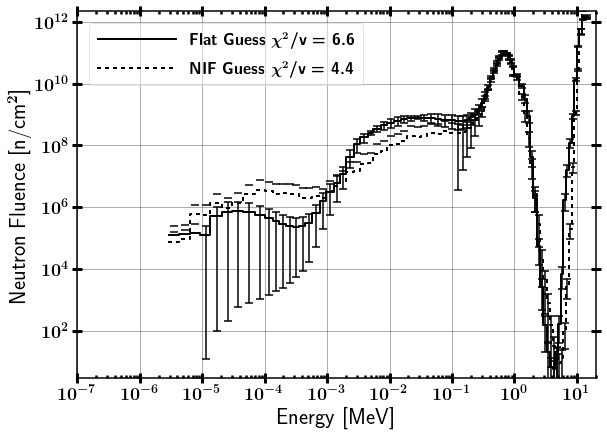

In [56]:
print len(fiterAdjHisto)
iter = 0
fiterAdjHisto[iter].build_histo(fiterSoln[iter]._df['lowE'].tolist(),fiterSoln[iter]._df['adjFlux'].tolist(),
                             uncert=(fiterSoln[iter]._df['adjStd']*fiterSoln[iter]._df['adjFlux']).tolist(),
                             edgeLoc='low', name='\\textbf{Flat Guess $\chi^{2}$/v = 6.6}')
#'Flat Guess-$\chi^{2}$ $\nu$ = 6.6')

fiterAdjHisto[iter].plot(iterAdjHisto[iter],xMin=1E-8, xMax=16, logX=False, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',legendLoc=4,
                        savePath=outpath+'PinBoth',)
fiterAdjHisto[iter].plot(iterAdjHisto[iter],xMin=1E-7, xMax=20, logX=True, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',legendLoc=2,
                        savePath=outpath+'PinBothLog')

# Basket
All values except for STAYSL are the same. Foil thicknesses are the same
Uncertainty in 13-14 MeV bins is set to 50%. Lower is set to 100%

In [82]:
from Unfolding.STAYSL import IterativeSTAYSL

path = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/stayslin.out'
df = pd.read_table(path, engine='python', sep='\s+', skiprows=101, skipfooter=649, header=None,
                   names=['lowE', 'adjFlux', 'unadjFlux', 'fluxRatio', 'adjStd', 
                          'unadjStd', 'uncertRatio', 'integralFlux', 'intFluxUncert'])

df.apply(pd.to_numeric)

df['adjFlux'] = bin_integration(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low')
df['adjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low', True)
df['unadjFlux'] = bin_integration(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low')
df['unadjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low', True)

df['adjLethargyStd'] = df['adjStd'] * df['adjLethargy'] / 100
df['unadjLethargyStd'] = df['unadjStd'] * df['adjLethargy'] / 100
df['adjStd'] = df['adjStd'] * df['adjFlux'] / 100
df['unadjStd'] = df['unadjStd'] * df['unadjFlux'] / 100

#df['adjStd']

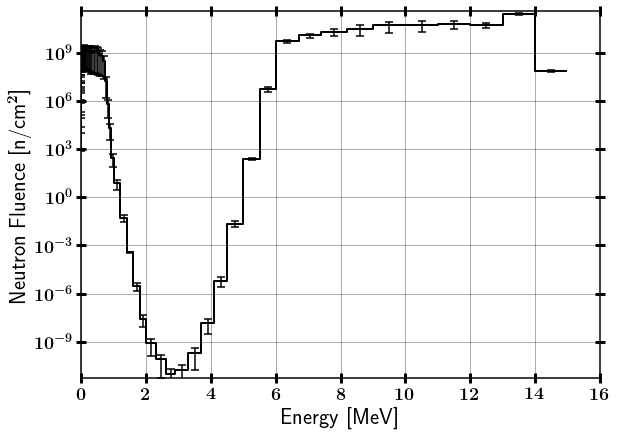

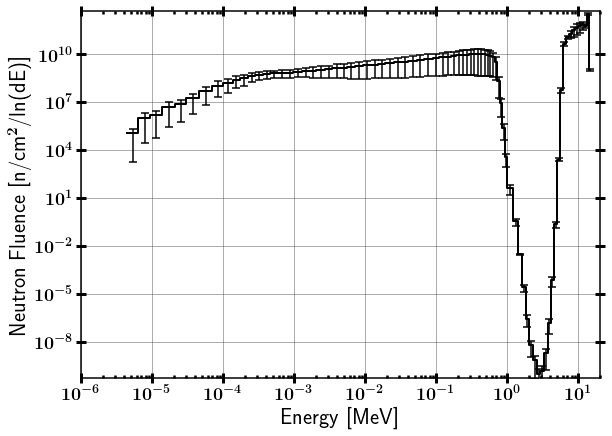

In [83]:
outpath ='C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/'
adjHisto = Histogram()
adjHisto.build_histo(df['lowE'].tolist(), df['adjFlux'].tolist(), uncert=df['adjStd'].tolist(),
                     edgeLoc='low')

adjHisto.plot(xMin=1E-6, logX=False, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',
                  savePath=outpath+'Bask',includeMarkers=False,
                  legend=False)
adjLethargyHisto = Histogram()
adjLethargyHisto.build_histo(df['lowE'].tolist(), df['adjLethargy'].tolist(), uncert=df['adjLethargyStd'].tolist(),
                     edgeLoc='low')

adjLethargyHisto.plot( xMin=1E-6,xMax=20.0,logX=True, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$/ln(dE)]',
                  savePath=outpath+'Bask_Lethargic',includeMarkers=False,
                  legend=False)

# Bask Iterative Solution:
  - The iterative solution sets the uncertainty to 100%.
  - It does not update the uncertainty until $\chi^2$ converged.
  - Less is known about this flux. 
  - The starting guess spectrum is still the source term for the pin; however, it is scaled by the divergence (7^2/41^2)

In [84]:
from Unfolding.STAYSL import IterativeSTAYSL

stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration1/'

# Build Data Structure Lists
iterSoln = []
iterAdjHisto = []
iterRatioHisto = []

iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=False, chiConv=0.1))
print iterSoln[-1]

iterSoln[-1].run()

# Convert to lethargy
iterSoln[-1]._df['adjLethargy'] =  bin_differentiation(iterSoln[-1]._df['lowE'].tolist(),
                                                     iterSoln[-1]._df['adjFlux'].tolist(), 'low', True)

# Add to plot lists
iterAdjHisto.append(Histogram())
iterRatioHisto.append(Histogram())

IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration1/
$\chi^2$ Convergence: 0.1
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: False
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration1/stayslin.out
Chi^2 = 475.10489, Std Norm = 6.97065146095
Chi^2 = 74.96529
Chi^2 = 6.61176
Chi^2 = 24.74729
Chi^2 = -23.48782
Chi^2 = 28.43888
Chi^2 = 18.62307
Chi^2 = 18.67792
Std Norm = 7.40700646685, 7.6985038553
Std Norm = 7.54325488367, 7.40700646685
Std Norm = 7.20909321898, 7.54325488367
Std Norm = 6.9346168719, 7.20909321898
Std Norm = 6.95270965308, 6.9346168719


1


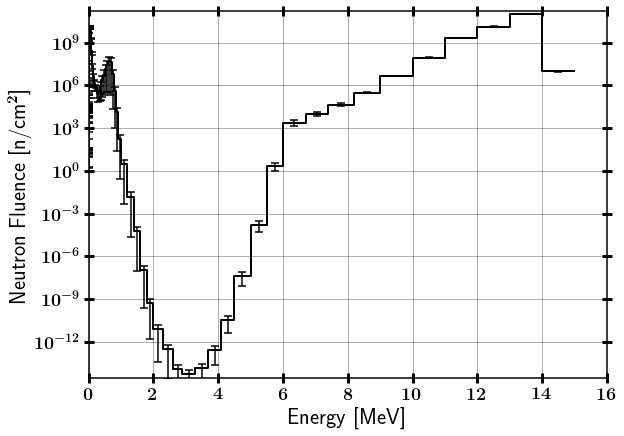

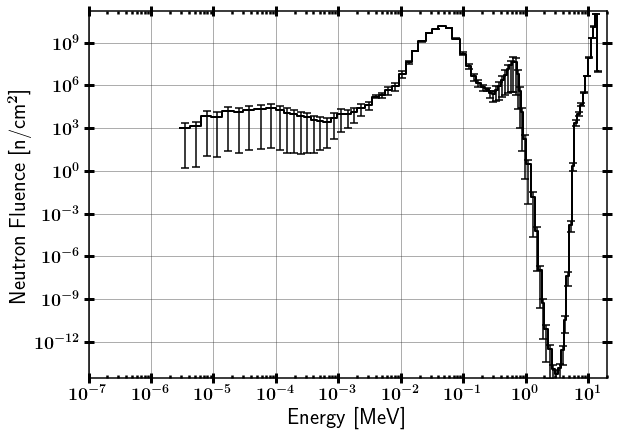

In [85]:
print len(iterAdjHisto)
iter = 0
iterAdjHisto[iter].build_histo(iterSoln[iter]._df['lowE'].tolist(),iterSoln[iter]._df['adjFlux'].tolist(),
                             uncert=(iterSoln[iter]._df['adjStd']*iterSoln[iter]._df['adjFlux']).tolist(),
                             edgeLoc='low', name= '\\textbf{NIF Guess $\chi^{2}$/v = 18.7}')

iterAdjHisto[iter].plot(xMin=1E-8, xMax=16, logX=False, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',legend=False,
                        savePath=outpath+'Bask-Unfold_Itr{:1d}'.format(iter))
iterAdjHisto[iter].plot(xMin=1E-7, xMax=20, logX=True, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',legend=False,
                        savePath=outpath+'Basklog-Unfold_Itr{:1d}'.format(iter))



Find the p-value

In [61]:
crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 5)   # Df = number of variable categories - 1

print("Critical value")
print(crit)

p_value= stats.chi2.sf(18.7*5, 5) 
print("P value")
print(p_value)

Critical value
11.0704976935
P value
1.23488858342e-18


# Basket Results
- Starting from Flat Spectrum 

In [86]:


path = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/BASK_N120405_flat/stayslin.out'
df = pd.read_table(path, engine='python', sep='\s+', skiprows=101, skipfooter=649, header=None,
                   names=['lowE', 'adjFlux', 'unadjFlux', 'fluxRatio', 'adjStd', 
                          'unadjStd', 'uncertRatio', 'integralFlux', 'intFluxUncert'])

df.apply(pd.to_numeric)

df['adjFlux'] = bin_integration(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low')
df['adjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low', True)
df['unadjFlux'] = bin_integration(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low')
df['unadjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low', True)

df['adjLethargyStd'] = df['adjStd'] * df['adjLethargy'] / 100
df['unadjLethargyStd'] = df['unadjStd'] * df['adjLethargy'] / 100
df['adjStd'] = df['adjStd'] * df['adjFlux'] / 100
df['unadjStd'] = df['unadjStd'] * df['unadjFlux'] / 100

#df['adjStd']

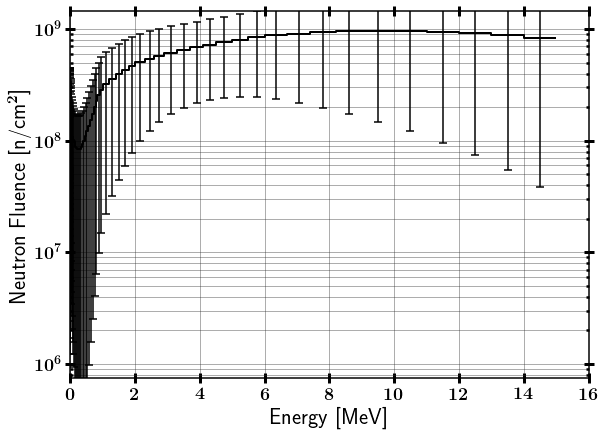

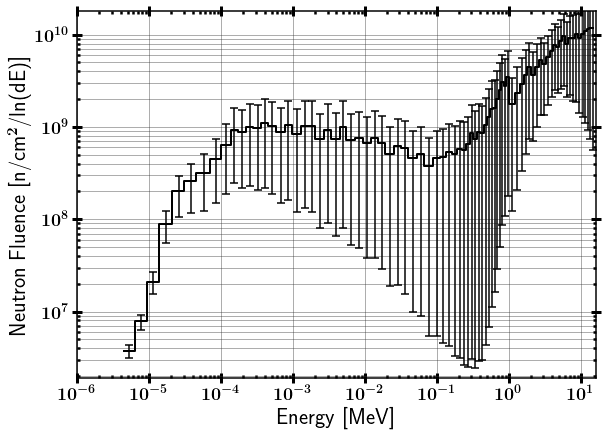

In [87]:
from DataAnalysis.Histograms import Histogram
import matplotlib
%matplotlib inline

outpath ='C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/BASK_N120405_flat/'
fadjHisto = Histogram()
fadjHisto.build_histo(df['lowE'].tolist(), df['adjFlux'].tolist(), uncert=df['adjStd'].tolist(),
                     edgeLoc='low')

fadjHisto.plot(xMin=1E-6, logX=False, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',
                  savePath=outpath+'Pin1',includeMarkers=False,
                  legend=False)
fadjLethargyHisto = Histogram()
fadjLethargyHisto.build_histo(df['lowE'].tolist(), df['adjLethargy'].tolist(), uncert=df['adjLethargyStd'].tolist(),
                     edgeLoc='low')

fadjLethargyHisto.plot( xMin=1E-6, logX=True, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$/ln(dE)]',
                  savePath=outpath+'Pin1d_Lethargic',includeMarkers=False,
                  legend=False)

# Flat Spectrum Basket Iterative Solution:
  - Start from Flat spectrum
  - The iterative solution sets all uncertainties to 100%
  - It does not update the uncertainty until $\chi^2$ converged.

In [88]:

stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/BASK_N120405_flat/Iteration1/'

# Build Data Structure Lists
fiterSoln = []
fiterAdjHisto = []
fiterRatioHisto = []

fiterSoln.append(IterativeSTAYSL(stayslPath, updateStd=False, chiConv=0.1))
print iterSoln[-1]

fiterSoln[-1].run()

# Convert to lethargy
fiterSoln[-1]._df['adjLethargy'] =  bin_differentiation(fiterSoln[-1]._df['lowE'].tolist(),
                                                     fiterSoln[-1]._df['adjFlux'].tolist(), 'low', True)

# Add to plot lists
fiterAdjHisto.append(Histogram())
fiterRatioHisto.append(Histogram())

IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration1/
$\chi^2$ Convergence: 0.1
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: True
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/BASK_N120405_flat/Iteration1/stayslin.out
Chi^2 = 3292.59, Std Norm = 7.67112011899
Chi^2 = 532.90581
Chi^2 = 22.04437
Chi^2 = 836.42393
Chi^2 = 168.8195
Chi^2 = 38.32789
Chi^2 = 18.04393
Chi^2 = 18.38839
Chi^2 = 17.80932
Chi^2 = 17.72466
Std Norm = 7.46272445224, 7.75180304123
Std Norm = 7.22386287038, 7.46272445224
Std Norm = 7.28959225197, 7.22386287038


1


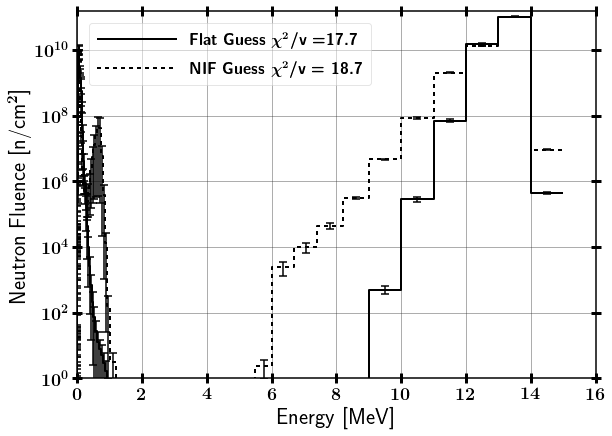

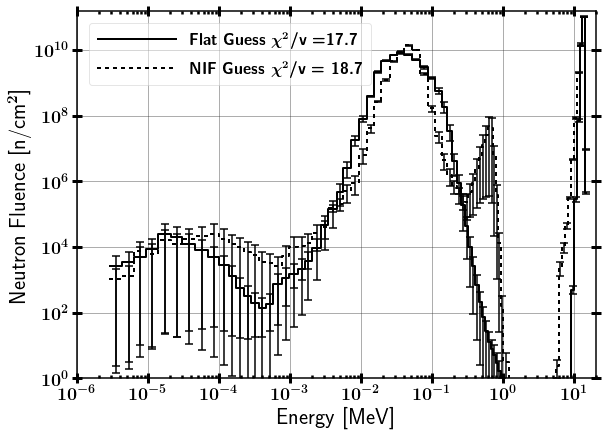

In [103]:
print len(fiterAdjHisto)
iter = 0
fiterAdjHisto[iter].build_histo(fiterSoln[iter]._df['lowE'].tolist(),fiterSoln[iter]._df['adjFlux'].tolist(),
                             uncert=(fiterSoln[iter]._df['adjStd']*fiterSoln[iter]._df['adjFlux']).tolist(),
                             edgeLoc='low', name='\\textbf{Flat Guess $\chi^{2}$/v =17.7}')

fiterAdjHisto[iter].plot(iterAdjHisto[iter],xMin=1E-8, xMax=16,yMin=1, logX=False, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',legendLoc=2,
                        savePath=outpath+'BaskBoth',)
fiterAdjHisto[iter].plot(iterAdjHisto[iter],xMin=1E-6, xMax=20, yMin=1,logX=True, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',legendLoc=2,
                        savePath=outpath+'BaskBothLog')

In [66]:
p_value= stats.chi2.sf(17.7*5, 5) 
print("P value")
print(p_value)

P value
1.38784133329e-17


# Kinematic Base
All values except for STAYSL are the same. Foil thicknesses are the same

In [104]:
from Unfolding.STAYSL import IterativeSTAYSL

path = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/KBAS_N120405_iter/stayslin.out'
df = pd.read_table(path, engine='python', sep='\s+', skiprows=101, skipfooter=649, header=None,
                   names=['lowE', 'adjFlux', 'unadjFlux', 'fluxRatio', 'adjStd', 
                          'unadjStd', 'uncertRatio', 'integralFlux', 'intFluxUncert'])

df.apply(pd.to_numeric)

df['adjFlux'] = bin_integration(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low')
df['adjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low', True)
df['unadjFlux'] = bin_integration(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low')
df['unadjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low', True)

df['adjLethargyStd'] = df['adjStd'] * df['adjLethargy'] / 100
df['unadjLethargyStd'] = df['unadjStd'] * df['adjLethargy'] / 100
df['adjStd'] = df['adjStd'] * df['adjFlux'] / 100
df['unadjStd'] = df['unadjStd'] * df['unadjFlux'] / 100

#df['adjStd']

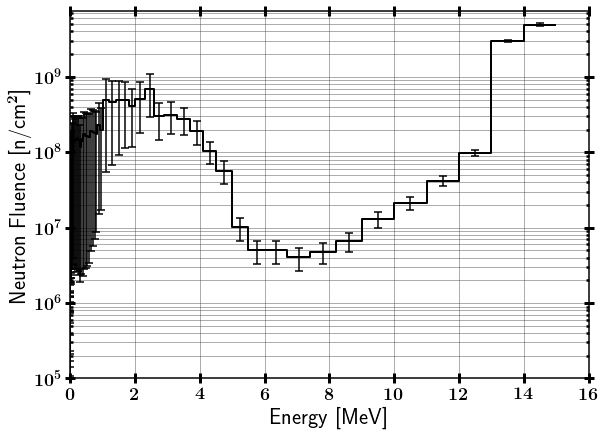

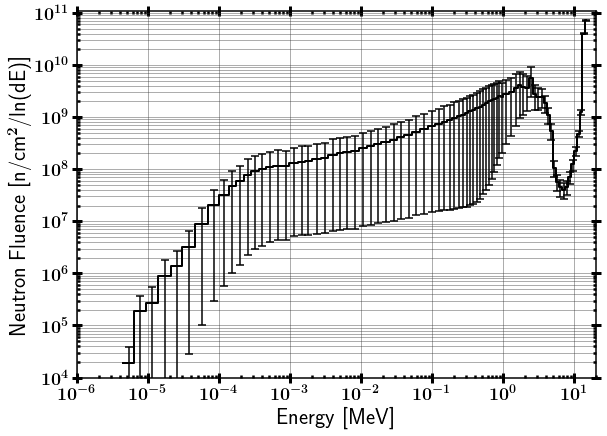

In [105]:
outpath ='C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/KBAS_N120405_iter/'
adjHisto = Histogram()
adjHisto.build_histo(df['lowE'].tolist(), df['adjFlux'].tolist(), uncert=df['adjStd'].tolist(),
                     edgeLoc='low')

adjHisto.plot(xMin=1E-6, yMin=1E5,logX=False, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',
                  savePath=outpath+'KBAS_init',includeMarkers=False,
                  legend=False)
adjLethargyHisto = Histogram()
adjLethargyHisto.build_histo(df['lowE'].tolist(), df['adjLethargy'].tolist(), uncert=df['adjLethargyStd'].tolist(),
                     edgeLoc='low')

adjLethargyHisto.plot( xMin=1E-6,xMax=20.0,logX=True, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$/ln(dE)]',
                  savePath=outpath+'KBAS_Lethargic_init',includeMarkers=False,
                  legend=False)

# KBAS Iterative Solution:
  - The iterative solution sets the uncertainty to 100%.
  - It does not update the uncertainty until $\chi^2$ converged.
  - Less is known about this flux. 
  - The starting guess spectrum is still the source term for the pin; however, it is scaled by the divergence (7^2/41^2

In [106]:
from Unfolding.STAYSL import IterativeSTAYSL

stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/KBAS_N120405_iter/Iteration1/'

# Build Data Structure Lists
iterSoln = []
iterAdjHisto = []
iterRatioHisto = []

iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=False, chiConv=0.1))
print iterSoln[-1]

iterSoln[-1].run()

# Convert to lethargy
iterSoln[-1]._df['adjLethargy'] =  bin_differentiation(iterSoln[-1]._df['lowE'].tolist(),
                                                     iterSoln[-1]._df['adjFlux'].tolist(), 'low', True)

# Add to plot lists
iterAdjHisto.append(Histogram())
iterRatioHisto.append(Histogram())

IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/KBAS_N120405_iter/Iteration1/
$\chi^2$ Convergence: 0.1
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: False
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/KBAS_N120405_iter/Iteration1/stayslin.out
Chi^2 = 1164.57866, Std Norm = 7.6755514297
Chi^2 = 22.19978
Chi^2 = 0.38453
Chi^2 = 0.35193
Std Norm = 5.53935090873, 6.37904563473
Std Norm = 5.05022266539, 5.53935090873
Std Norm = 4.69678499508, 5.05022266539
Std Norm = 4.42026383375, 4.69678499508
Std Norm = 4.19357569861, 4.42026383375
Std Norm = 4.00287708904, 4.19357569861
Std Norm = 3.83961195696, 4.00287708904
Std Norm = 3.69800199026, 3.83961195696
Std Norm = 3.57376078522, 3.69800199026
Std Norm = 3.46358394874, 3.57376078522
Std Norm = 3.36508592609, 3.46358394874


1


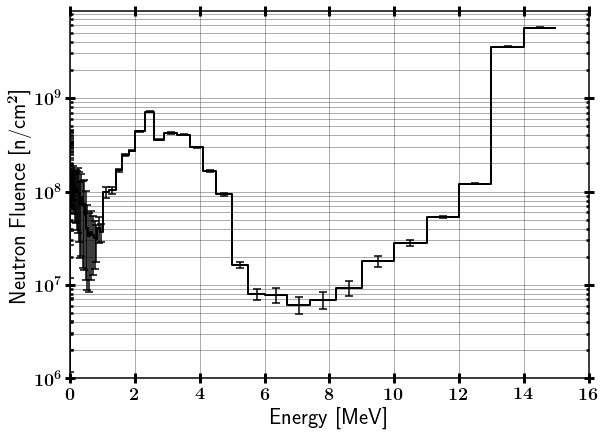

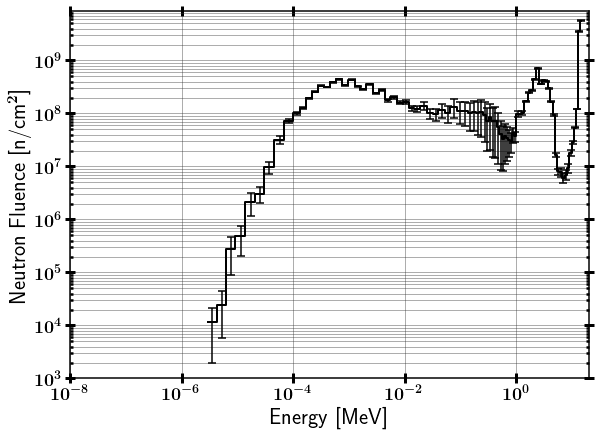

In [107]:
print len(iterAdjHisto)
iter = 0
iterAdjHisto[iter].build_histo(iterSoln[iter]._df['lowE'].tolist(),iterSoln[iter]._df['adjFlux'].tolist(),
                             uncert=(iterSoln[iter]._df['adjStd']*iterSoln[iter]._df['adjFlux']).tolist(),
                             edgeLoc='low', name='\\textbf{NIF Guess $\chi^{2}$/v = 0.4}')

iterAdjHisto[iter].plot(xMin=1E-8, xMax=16, yMin=1e6, logX=False, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',legend=False,
                        savePath=outpath+'KBAS-Unfold_Itr{:1d}'.format(iter))
iterAdjHisto[iter].plot(xMin=1E-8, xMax=20, yMin=1000, logX=True, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',legend=False,
                        savePath=outpath+'KBASlog-Unfold_Itr{:1d}'.format(iter))

find the p-value

In [116]:
crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 5)   # Df = number of variable categories - 1

print("Critical value")
print(crit)

p_value= stats.chi2.sf(0.35*5., 5) 
print("P value")
print(p_value)

Critical value
11.0704976935
P value
0.882541374099


# Kinematic Base Results
- Starting from Flat Spectrum 

In [109]:
path = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/KBAS_N120405_flat/stayslin.out'
df = pd.read_table(path, engine='python', sep='\s+', skiprows=101, skipfooter=649, header=None,
                   names=['lowE', 'adjFlux', 'unadjFlux', 'fluxRatio', 'adjStd', 
                          'unadjStd', 'uncertRatio', 'integralFlux', 'intFluxUncert'])

df.apply(pd.to_numeric)

df['adjFlux'] = bin_integration(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low')
df['adjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low', True)
df['unadjFlux'] = bin_integration(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low')
df['unadjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low', True)

df['adjLethargyStd'] = df['adjStd'] * df['adjLethargy'] / 100
df['unadjLethargyStd'] = df['unadjStd'] * df['adjLethargy'] / 100
df['adjStd'] = df['adjStd'] * df['adjFlux'] / 100
df['unadjStd'] = df['unadjStd'] * df['unadjFlux'] / 100

#df['adjStd']

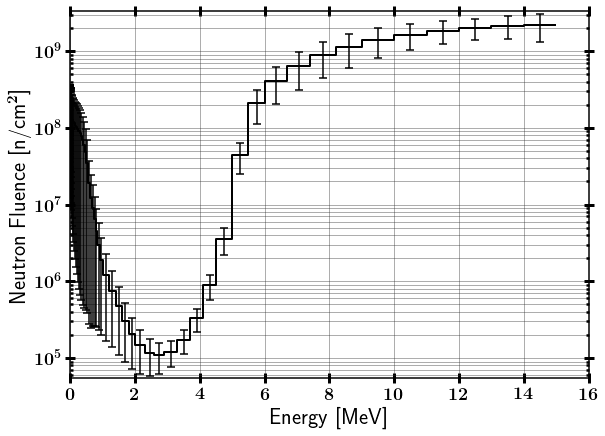

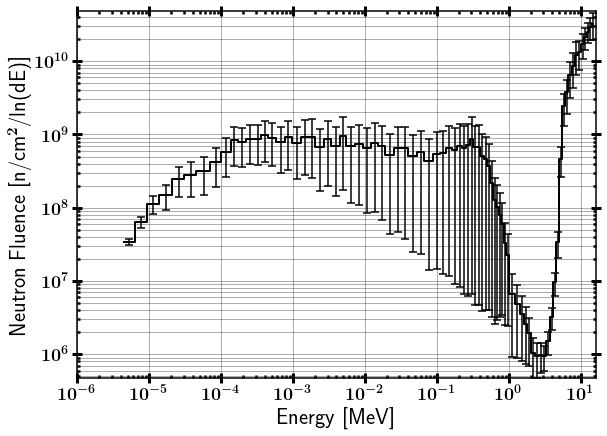

In [110]:
outpath ='C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/KBAS_N120405_flat/'
fadjHisto = Histogram()
fadjHisto.build_histo(df['lowE'].tolist(), df['adjFlux'].tolist(), uncert=df['adjStd'].tolist(),
                     edgeLoc='low')

fadjHisto.plot(xMin=1E-6, logX=False, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',
                  savePath=outpath+'FLATKBAS',includeMarkers=False,
                  legend=False)
fadjLethargyHisto = Histogram()
fadjLethargyHisto.build_histo(df['lowE'].tolist(), df['adjLethargy'].tolist(), uncert=df['adjLethargyStd'].tolist(),
                     edgeLoc='low')

fadjLethargyHisto.plot( xMin=1E-6, logX=True, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$/ln(dE)]',
                  savePath=outpath+'flatKBASd_Lethargic',includeMarkers=False,
                  legend=False)

# Flat Spectrum KBAS Iterative Solution:
  - Start from Flat spectrum
  - The iterative solution sets all uncertainties to 100%
  - It does not update the uncertainty until $\chi^2$ converged.

In [111]:
stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/KBAS_N120405_flat/Iteration1/'

# Build Data Structure Lists
fiterSoln = []
fiterAdjHisto = []
fiterRatioHisto = []

fiterSoln.append(IterativeSTAYSL(stayslPath, updateStd=False, chiConv=0.1))
print iterSoln[-1]

fiterSoln[-1].run()

# Convert to lethargy
fiterSoln[-1]._df['adjLethargy'] =  bin_differentiation(fiterSoln[-1]._df['lowE'].tolist(),
                                                     fiterSoln[-1]._df['adjFlux'].tolist(), 'low', True)

# Add to plot lists
fiterAdjHisto.append(Histogram())
fiterRatioHisto.append(Histogram())

IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/KBAS_N120405_iter/Iteration1/
$\chi^2$ Convergence: 0.1
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: True
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/KBAS_N120405_flat/Iteration1/stayslin.out
Chi^2 = 422.62758, Std Norm = 6.54619486878
Chi^2 = 21.95782
Chi^2 = 2.48518
Chi^2 = 0.72833
Chi^2 = 0.56462
Chi^2 = 0.53715
Std Norm = 5.68501144766, 6.45500306119
Std Norm = 5.29381910817, 5.68501144766
Std Norm = 5.05348573759, 5.29381910817
Std Norm = 4.88217752033, 5.05348573759
Std Norm = 4.74559276487, 4.88217752033
Std Norm = 4.62897467913, 4.74559276487
Std Norm = 4.52603803563, 4.62897467913
Std Norm = 4.43376483138, 4.52603803563


1


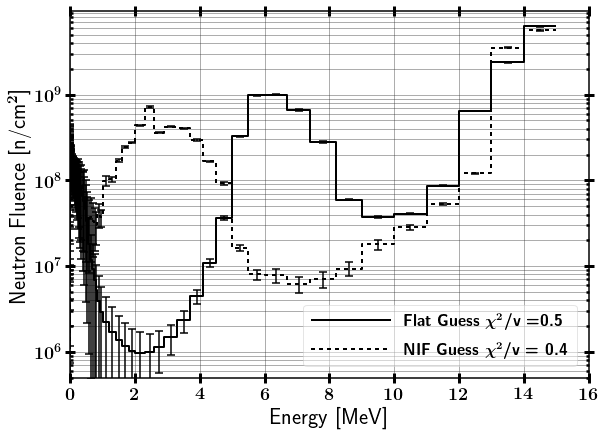

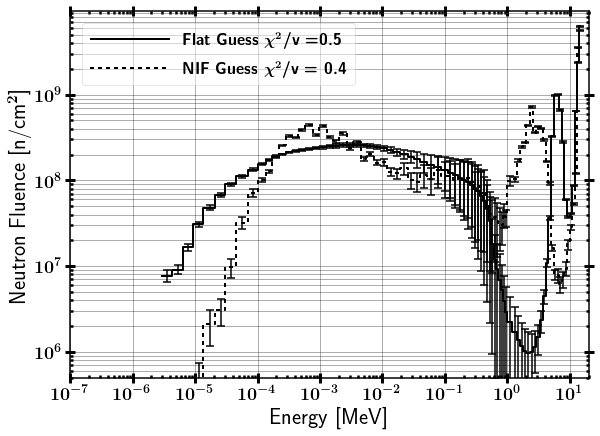

In [112]:
print len(fiterAdjHisto)
iter = 0
fiterAdjHisto[iter].build_histo(fiterSoln[iter]._df['lowE'].tolist(),fiterSoln[iter]._df['adjFlux'].tolist(),
                             uncert=(fiterSoln[iter]._df['adjStd']*fiterSoln[iter]._df['adjFlux']).tolist(),
                             edgeLoc='low', name='\\textbf{Flat Guess $\chi^{2}$/v =0.5}')

fiterAdjHisto[iter].plot(iterAdjHisto[iter],xMin=1E-8, xMax=16, logX=False, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',legendLoc=4,
                        savePath=outpath+'KBASBoth',)
fiterAdjHisto[iter].plot(iterAdjHisto[iter],xMin=1E-7, xMax=20, logX=True, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',legendLoc=2,
                        savePath=outpath+'KBASBothLog')


In [115]:
crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 4)   # Df = number of variable categories - 1

print("Critical value")
print(crit)

p_value= stats.chi2.sf(5.*0.5, 5) 
print("P value")
print(p_value)

Critical value
9.48772903678
P value
0.776495071123
